<a href="https://colab.research.google.com/github/alimomennasab/CS4210/blob/main/4210FinalProjectCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS4210-02 Machine Learning
## Fall 2024 Semester Project
Convolutional neural network model that classifies fish/shrimp from an image
### Members:
- Ali Momennasab
- Denise Thuong
- Eli Tolentino
- Armin Erika Polanco
- Sarah Choe
- Damian Varela


##Imports

In [ ]:
import kagglehub
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import PIL

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from pathlib import Path

##Data Preprocessing

In [ ]:
# Download latest version
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.24G/3.24G [02:26<00:00, 23.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2


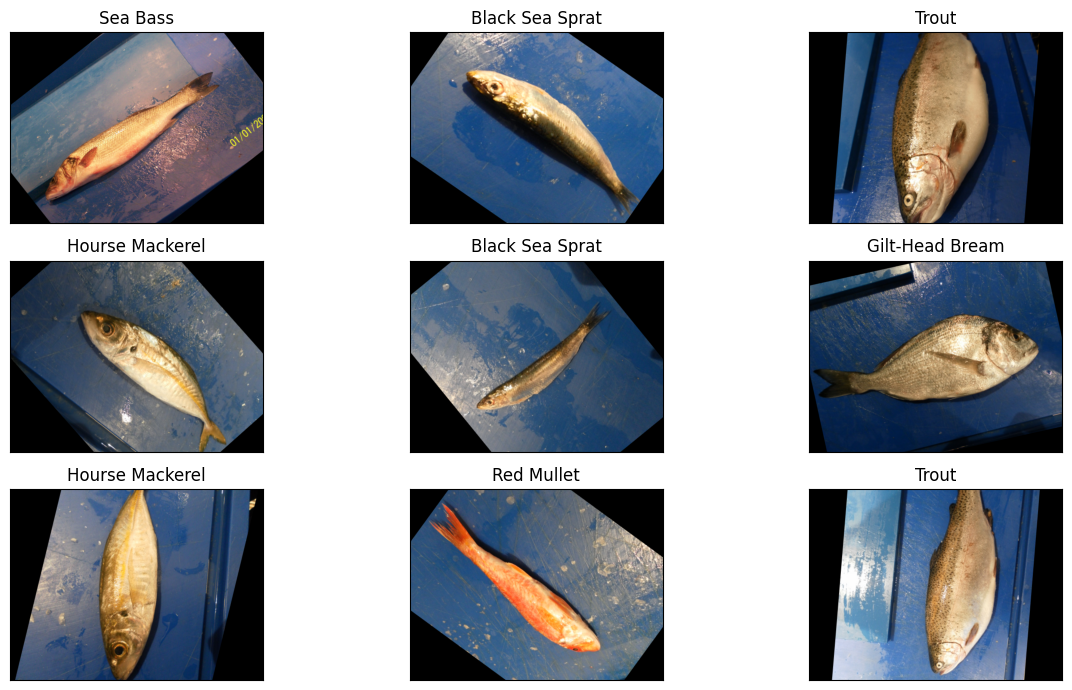

In [ ]:
# Cleaning dataset
direc = Path(path)
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ] # ground truth binary masks not needed for classification

img_df = img_df[img_df['FilePaths'].str.endswith('.png')].reset_index(drop=True) # keep only pngs

# Shuffle images and display 9 random images
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

In [ ]:
# Data analysis
img_df.shape

(9281, 2)

In [ ]:
# Data analysis
img_df.columns

Index(['FilePaths', 'Labels'], dtype='object')

In [ ]:
# Checking to see if all images have the same resolution
shape_counts = {}

for idx, filepath in enumerate(img_df.FilePaths):
    try:
        img = PIL.Image.open(filepath)
        shape = np.array(img).shape

        # Store the count of each shape
        if shape in shape_counts:
            shape_counts[shape] += 1
        else:
            shape_counts[shape] = 1

    except:
      img_df.drop(idx, inplace=True)

print("Image shape distribution:")
for shape, count in shape_counts.items():
    print(f"Shape {shape}: {count} images")

Image shape distribution:
Shape (445, 590, 3): 9000 images
Shape (768, 1024, 3): 178 images
Shape (2128, 2832, 3): 103 images


In [ ]:
# Delete original, non-augmented photos that have different sizing/resolution
for index in img_df.index:
    try:
        img = plt.imread(img_df.FilePaths[index])
        if img.shape != (445, 590, 3):
            img_df.drop(index, inplace=True)
    except:
        # If we can't read the image, drop it
        img_df.drop(index, inplace=True)

img_df.shape

(9000, 2)

In [ ]:
# Split 9k image dataset into 8k training and 1k testing
train_df, test_df = train_test_split(img_df, train_size=8000, random_state=1)
print("training df shape: " + str(train_df.shape))
print("test_df.shape: " + str(test_df.shape))

# Getting labels
train_labels = train_df.Labels
test_labels = test_df.Labels

# Use data generator for loading training data to save memory
datagen = ImageDataGenerator()
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="FilePaths",
    y_col="Labels",
    batch_size=32,
    target_size=(445, 590),
    class_mode='categorical')

# Generator for testing data
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="FilePaths",
    y_col="Labels",
    batch_size=32,
    target_size=(445, 590),
    class_mode='categorical',
    shuffle=False)

training df shape: (8000, 2)
test_df.shape: (1000, 2)
Found 8000 validated image filenames belonging to 9 classes.
Found 1000 validated image filenames belonging to 9 classes.


##Model Implementation

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(445, 590, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(img_df.Labels.unique()), activation='softmax')  # number of fish classes
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 443, 588, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 221, 294, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 219, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 109, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 107, 144, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 53, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 51, 70, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 25, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 23, 33, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 11, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 22528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,441,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,720,201 (6.56 MB)

 Trainable params: 1,720,201 (6.56 MB)

 Non-trainable params: 0 (0.00 B)

##Training

In [ ]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

model.fit(train_generator, epochs=20, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 146s 492ms/step - accuracy: 0.2580 - loss: 5.7217
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 127s 498ms/step - accuracy: 0.6530 - loss: 0.9805
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 127s 496ms/step - accuracy: 0.7987 - loss: 0.5905
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 496ms/step - accuracy: 0.9017 - loss: 0.3143
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 499ms/step - accuracy: 0.9267 - loss: 0.2165
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 501ms/step - accuracy: 0.9454 - loss: 0.1702
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 495ms/step - accuracy: 0.9608 - loss: 0.1159
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 497ms/step - accuracy: 0.9742 - loss: 0.0790
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 500ms/step - accuracy: 0.9750 - loss: 0.0891
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 502ms/step - accuracy: 0.9787 - loss: 0.0636
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 496ms/step - accuracy: 0.9533 - loss: 0.1958
Epoch 12/20
250/250

In [ ]:
model.save('fish_model.keras')

##Testing

In [ ]:
predictions = model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# evaluation metrics: confusion matrix, accuracy, classification report, kappa
print(confusion_matrix(true_labels, predicted_labels))
print("Accuracy:", accuracy_score(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))
print("Kappa: ", cohen_kappa_score(true_labels, predicted_labels))

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 483ms/step
[[120   1   0   0   0   0   0   0   0]
 [  0  99   0   0   0   0   0   0   0]
 [  0   0 115   0   0   0   0   1   1]
 [  0   0   0 109   0   0   0   0   0]
 [  0   0   0   0  96   0   0   1   0]
 [  0   0   0   0   0 130   0   0   0]
 [  0   0   0   0   0   0 113   0   0]
 [  0   0   0   0   0   0   0 102   0]
 [  0   0   0   0   0   0   0   0 112]]
Accuracy: 0.996
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       121
           1       0.99      1.00      0.99        99
           2       1.00      0.98      0.99       117
           3       1.00      1.00      1.00       109
           4       1.00      0.99      0.99        97
           5       1.00      1.00      1.00       130
           6       1.00      1.00      1.00       113
           7       0.98      1.00      0.99       102
           8       0.99      1.00      1.00       112

    accuracy                           1.00     